In [22]:
from shared.preface import *
import shared.functions as fct

import scipy.stats as stat

def bin_volumes(radial_bins):
    """Returns the volumes of the bins. """

    single_vol = lambda x: (4.0 / 3.0) * np.pi * x ** 3
    outer = single_vol(radial_bins[1:])
    inner = single_vol(radial_bins[:-1])
    return outer - inner


def bin_centers(radial_bins):
    """Returns the centers of the bins. """

    outer = radial_bins[1:]
    inner = radial_bins[:-1]
    return 0.5 * (outer + inner)


def analyse_halo(mass, pos):
    # Define radial bins [log scale, kpc units]
    radial_bins = np.arange(0, 5, 0.1)
    radial_bins = 10 ** radial_bins

    # Radial coordinates [kpc units]
    r = np.sqrt(np.sum(pos ** 2, axis=1))

    SumMasses, _, _ = stat.binned_statistic(
        x=r, values=np.ones(len(r)) * mass[0], 
        statistic="sum", bins=radial_bins
    )
    density = (SumMasses / bin_volumes(radial_bins))  # Msun/kpc^3
    return density

### Extract MW type halos.

In [46]:
def read_data(which_halos, name, mass_select):

    # Open data files.
    folder = '/home/fabian/ownCloud/sim_data'
    snaps = h5py.File(f'{folder}/snapshot_0036.hdf5')
    group = h5py.File(f'{folder}/subhalo_0036.catalog_groups')
    parts = h5py.File(f'{folder}/subhalo_0036.catalog_particles')
    props = h5py.File(f'{folder}/subhalo_0036.properties')

    ### Properties of DM particles.

    # Positions.
    a = snaps["/Header"].attrs["Scale-factor"]
    pos = snaps['PartType1/Coordinates'][:][:] * a  #? in kpc?

    # Masses.
    mass = snaps['PartType1/Masses'][:] * 1e10  #? now in Msun?

    # Velocities.
    vel = snaps['PartType1/Velocities'][:][:]  #? in kpc/s?


    ### Critical M_200.
    m200c = props['Mass_200crit'][:] * 1e10  # now in Msun

    # Set neg. values to 1, i.e. 0 in np.log10.
    m200c[m200c <= 0] = 1

    # Exponent of 10^x, which reproduces m200c vals.
    m200c = np.log10(m200c)  

    # Center of Potential coordinates, for all halos.
    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]

    # Select halos based on exponent, i.e. mass_select input parameter.
    select_halos = np.where(
        (m200c >= mass_select-0.2) & (m200c <= mass_select+0.2)
    )[0]

    # Selecting subhalos or halos.
    subtype = props["Structuretype"][:]
    if which_halos == 'subhalos':
        select = np.where(subtype[select_halos] > 10)[0]
        select_halos = select_halos[select]
    else:
        select = np.where(subtype[select_halos] == 10)[0]
        select_halos = select_halos[select]

    #? why do we have to do this?
    if len(select_halos) >= 30:
        select_random = np.random.randint(len(select_halos) - 1, size=(30))
        # select_random = np.random.random_integers(len(select_halos) - 1, size=(30))
        select_halos = select_halos[select_random]

    # Convert selected halos back to Msun units.
    M200 = np.median(10 ** m200c[select_halos])

    # Bin centers in kpc.
    radial_bins = 10**np.arange(0, 5, 0.1)
    centers = bin_centers(radial_bins)

    # Calculate density for each bin center.
    density_all = np.zeros((len(centers), len(select_halos)))
    for j, halo_j in enumerate(select_halos):
        
        # Grab the start position in the particles file to read from
        halo_start_position = group["Offset"][halo_j]
        halo_end_position = group["Offset"][halo_j + 1]
        particle_ids_in_halo = parts["Particle_IDs"][halo_start_position:halo_end_position]
        particle_ids_from_snapshot = snaps["PartType1/ParticleIDs"][...]

        # Get indices of elements, which are present in both arrays.
        _, indices_v, indices_p = np.intersect1d(
            particle_ids_in_halo, particle_ids_from_snapshot, 
            assume_unique=True, return_indices=True
        )

        particles_mass = mass[indices_p] #? all the same masses?
        particles_pos = pos[indices_p, :]  # : grabs all 3 spatial positions.
        particles_pos -= CoP[halo_j, :]  # centering, w.r.t halo they're part of
        particles_pos *= 1e3  # to kpc
        density_all[:, j] = analyse_halo(particles_mass, particles_pos)

    # Statistics on densities.
    densityM = np.median(density_all[:, :], axis=1)
    densityUp = np.percentile(density_all[:, :], 84, axis=1)
    densityLow = np.percentile(density_all[:, :], 16, axis=1)

    # Output final median density profile.
    output = np.zeros((len(centers),4))
    output[:,0] = centers
    output[:,1] = densityM
    output[:,2] = densityLow
    output[:,3] = densityUp
    
    np.savetxt(
        f'sim_data/Profile_{which_halos}_M{mass_select}_{name}.txt',
        output, fmt='%s'
    )

for m in (10,11,12):
    read_data(which_halos='halos', name='learnSim', mass_select=m)

### Plot median density profile of various halo batches.

[9.92869868 8.30138213 0.         ... 0.         0.         0.        ]
3.4593959284118405


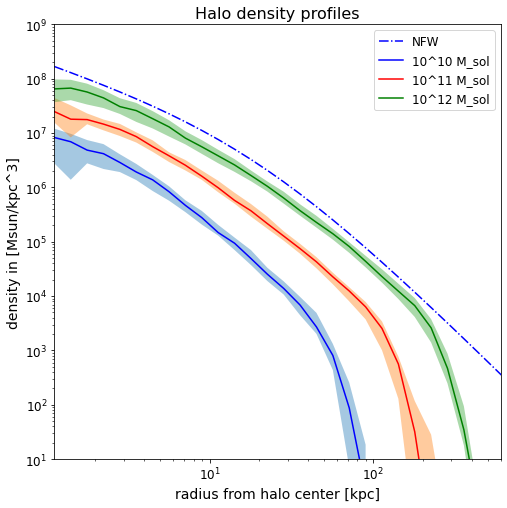

In [47]:
# Get NFW parameters from subhalo_properties.
props = h5py.File('/home/fabian/ownCloud/sim_data/subhalo_0036.properties')
cNFW = props['cNFW_200crit'][:]
rvir = props['R_200crit'][:] *1e3
print(cNFW)
# Use median.
cNFW, rvir = np.mean(cNFW), np.median(rvir)
rs = rvir/cNFW
print(rs)

fig = plt.figure(figsize=(8,8))

u1, u2 = kpc, Msun/kpc**3

ms = [10,11,12]
cs = ['blue', 'red', 'green']
which_halos, name = 'halos', 'learnSim'

for m, c in zip(ms, cs):
    f = np.loadtxt(
        f'sim_data/Profile_{which_halos}_M{m}_{name}.txt'
    )
    r, d, up, low = f[:,0]*u1, f[:,1]*u2, f[:,2]*u2, f[:,3]*u2
    
    if m==10:
        rho = np.mean(d)
        # NFW = fct.NFW_profile(r, rho, rs)
        NFW = fct.NFW_profile(r, rho0_MW, Rs_MW)
        plt.loglog(r/u1, NFW/u2, c=c, ls='-.', label='NFW')
    #     subf = np.loadtxt(f'sim_data/Profile_subhalos_M{m}_Test.txt')
    #     subr, subd, subUp, subLow = subf[:,0], subf[:,1], subf[:,2], subf[:,3]
    #     plt.loglog(subr, subd, label=f'10^{m} M_sol subhalo', ls=':')

    plt.loglog(r/u1, d/u2, c=c, label=f'10^{m} M_sol')
    plt.fill_between(r/u1, up/u2, low/u2, alpha=0.4)


plt.title('Halo density profiles')
plt.xlabel('radius from halo center [kpc]')
plt.ylabel('density in [Msun/kpc^3]')
plt.xlim(np.min(r/kpc), 600)
plt.ylim(1e1, 1e9)
plt.legend()
plt.show()